In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from numpy.random import seed
from nltk.tokenize.regexp import regexp_tokenize
from nltk.tokenize import RegexpTokenizer
seed(1)
from tensorflow import random
from sklearn.metrics import confusion_matrix, classification_report
random.set_seed(1)
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from keras.utils import to_categorical
from keras.optimizers import Adam

In [2]:
dataset = pd.read_csv("book1.csv")
dataset.head()

,sentiment,content
0,1,al thumama stadium hosts fan leaders moroccan ...
1,1,qatar becomes open museum preparation fifa wor...
2,1,fifa trade nfts historic plays ahead 2022 worl...
3,1,argentina goes crazy release panini official q...
4,1,minister municipality world cup qatar 2022 con...


In [3]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE)
    text = re.sub(r'#[A-Za-z0-9]+','',text)
    text = re.sub(r'@[A-Za-z0-9]+','',text)
    text = re.sub("'", "", text)
    text = re.sub('[()!?]', ' ', text)
    text = re.sub('\[.*?\]',' ', text)
    text = re.sub("[^a-z0-9]"," ", text)
    return text

hasil_cleaning = [clean_text(i) for i in dataset["content"]]

In [4]:
dataset = dataset.drop_duplicates('content')

In [5]:
regexp = RegexpTokenizer(r'\w+|$[0-9]+|\S+')
hasil_tokenize = []
for text in hasil_cleaning:
    tokens = regexp.tokenize(text)
    hasil_tokenize.append(tokens)

In [6]:
from nltk.corpus import stopwords
stopword = set(stopwords.words('english'))
hasil_filter = [[token for token in sub_list if token.lower() not in stopword] for sub_list in hasil_tokenize]

In [7]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
hasil_stemming = [[stemmer.stem(token) for token in text] for text in hasil_filter]

In [9]:
dataset["processing_result"] = hasil_stemming
pd.DataFrame(dataset).to_csv('Hasil Pp.csv', index=False, header=True)

In [10]:
df = pd.read_csv('Hasil Processing Imbalance.csv')
df.head()
print(df['sentiment'].unique())

[1 0 2]


In [11]:
contents = df['content']
sentiments = df['sentiment']

In [12]:
sentiments_count = sentiments.value_counts()
print(sentiments.value_counts())

1    200
0    150
2     90
Name: sentiment, dtype: int64


In [13]:
from sklearn.model_selection import train_test_split
X = contents
y = sentiments
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [15]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequence = tokenizer.texts_to_sequences(X)
max_length = max([len(s) for s in sequence])

X_train = pad_sequences(sequences_train, maxlen=max_length)
X_test = pad_sequences(sequences_test, maxlen=max_length)

In [16]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
vocab_size = 5000
embedding_dim = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(0.5))
model.add(LSTM(embedding_dim))
model.add(Dense(3, activation='softmax'))
optimizer = Adam(learning_rate=0.001)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          160000    
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 168,419
Trainable params: 168,419
Non-trainable params: 0
_________________________________________________________________


In [18]:
batch_size=16
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
22/22 [==============================] - 5s 35ms/step - loss: 1.0864 - accuracy: 0.4347 - val_loss: 1.0705 - val_accuracy: 0.4432
Epoch 2/50
22/22 [==============================] - 0s 9ms/step - loss: 1.0419 - accuracy: 0.4574 - val_loss: 1.0420 - val_accuracy: 0.4432
Epoch 3/50
22/22 [==============================] - 0s 9ms/step - loss: 0.9932 - accuracy: 0.4574 - val_loss: 1.0130 - val_accuracy: 0.4432
Epoch 4/50
22/22 [==============================] - 0s 8ms/step - loss: 0.9160 - accuracy: 0.4716 - val_loss: 0.9743 - val_accuracy: 0.4659
Epoch 5/50
22/22 [==============================] - 0s 10ms/step - loss: 0.7725 - accuracy: 0.6733 - val_loss: 0.9134 - val_accuracy: 0.6364
Epoch 6/50
22/22 [==============================] - 0s 9ms/step - loss: 0.6160 - accuracy: 0.8040 - val_loss: 0.7874 - val_accuracy: 0.6136
Epoch 7/50
22/22 [==============================] - 0s 8ms/step - loss: 0.4660 - accuracy: 0.8977 - val_loss: 0.8980 - val_accuracy: 0.5114
Epoch 8/50
22/22 [

In [19]:
accuracy = model.evaluate(X_test, y_test, verbose=2, batch_size=batch_size)
y_pred = model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

6/6 - 0s - loss: 1.0580 - accuracy: 0.6932 - 29ms/epoch - 5ms/step
3/3 [==============================] - 0s 5ms/step


In [ ]:
model.save("TestModelFix")

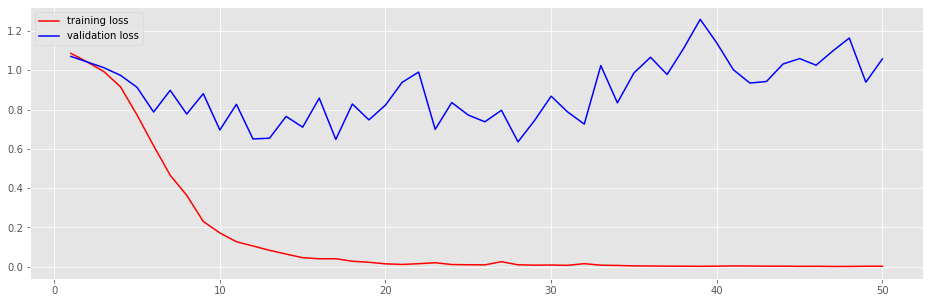

In [20]:
plt.figure(figsize=(16,5))
epochs = range(1, len(history.history['accuracy'])+1)
plt.plot(epochs, history.history['loss'], 'b', label='training loss', color='red')
plt.plot(epochs, history.history['val_loss'], 'b', label='validation loss')
plt.legend()
plt.show()

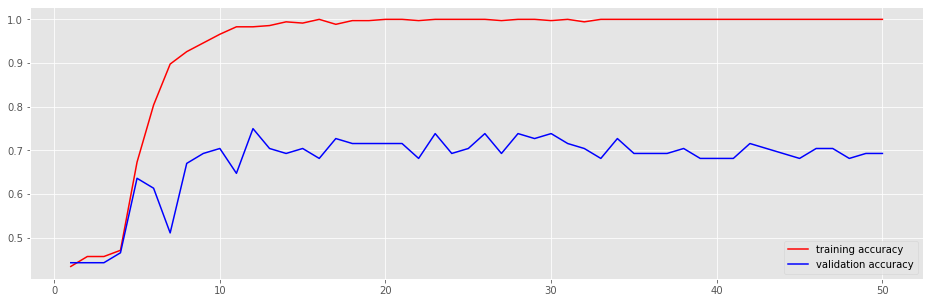

In [21]:
plt.figure(figsize=(16,5))
epochs = range(1, len(history.history['accuracy'])+1)
plt.plot(epochs, history.history['accuracy'], 'b', label='training accuracy', color='red')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[26  4  0]
 [12 27  0]
 [ 8  3  8]]


In [23]:
print(classification_report(y_test, y_pred, target_names=['Positive', 'Neutral', 'Negative']))

              precision    recall  f1-score   support

    Positive       0.57      0.87      0.68        30
     Neutral       0.79      0.69      0.74        39
    Negative       1.00      0.42      0.59        19

    accuracy                           0.69        88
   macro avg       0.79      0.66      0.67        88
weighted avg       0.76      0.69      0.69        88

